# Base model

In [1]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import pairwise_distances
import torch
import numpy as np
import os
from google.colab import drive

In [ ]:
pip install transformers

In [ ]:
drive.mount("/content/gdrive")
!pwd

In [9]:
suspicious_folder = "/content/gdrive/MyDrive/project_bert/suspicious"
dataset_folder = "/content/gdrive/MyDrive/project_bert/dataset"

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [10]:
def get_mean_pooling_embeddings(text, tokenizer, model):
    '''
    Esta funcion recibe un texto, un tokenizador y un modelo y devuelve el embedding
    promedio de las palabras del texto.

    Args:
    text: str: texto a tokenizar
    tokenizer: tokenizer: tokenizador
    model: model: modelo

    Returns:
    mean_pooled: torch.tensor: embedding promedio de las palabras del texto
    '''
    tokens = tokenizer.encode_plus(text, max_length=128,
                                    truncation=True, padding='max_length',
                                    return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state
        attention_mask = tokens['attention_mask']
        mask = attention_mask.unsqueeze(-1).expand(embeddings.shape).float()
        mask_embeddings = embeddings * mask
        summed = torch.sum(mask_embeddings, 1)
        counts = torch.clamp(mask.sum(1), min=1e-9)
        mean_pooled = summed / counts
        return mean_pooled

In [11]:
def load_texts_from_folder(folder_path):
    '''
    Esta funcion carga los textos de un directorio en una lista.
    :param folder_path: str, ruta al directorio que contiene los textos.
    :return: list, lista con los textos cargados.
    
    '''
    texts = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
                try:
                    text = file.read()
                    texts.append(text)
                except UnicodeDecodeError as e:
                    print(f"Error al decodificar el archivo {filepath}: {e}")
    return texts

In [12]:
suspicious_texts = load_texts_from_folder(suspicious_folder)
dataset_texts = load_texts_from_folder(dataset_folder)

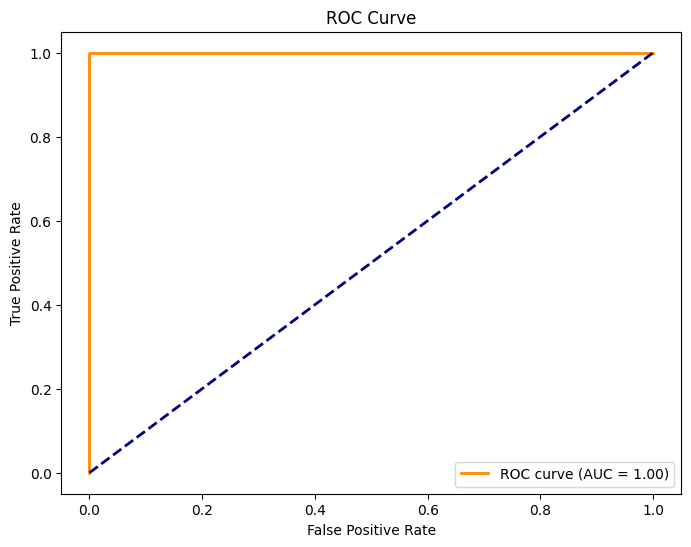

In [14]:
def plot_auc_curve(suspicious_texts, dataset_texts, tokenizer, model, threshold=0.85):

    '''
    Esta funcion calcula los embeddings de los textos en 'suspicious' y 'dataset' y luego calcula las similitudes de coseno
    entre todos los pares de embeddings. Finalmente, calcula la curva ROC y el AUC.
    :param suspicious_texts: lista de strings con los textos sospechosos
    :param dataset_texts: lista de strings con los textos del dataset
    :param tokenizer: tokenizer de Hugging Face
    :param model: modelo de Hugging Face
    :param threshold: umbral para clasificar si un par de textos es un par positivo o negativo

    '''
    suspicious_embeddings = [get_mean_pooling_embeddings(text, tokenizer, model) for text in suspicious_texts]

    dataset_embeddings = [get_mean_pooling_embeddings(text, tokenizer, model) for text in dataset_texts]

    suspicious_embeddings = np.array([emb.squeeze().detach().numpy() for emb in suspicious_embeddings])
    dataset_embeddings = np.array([emb.squeeze().detach().numpy() for emb in dataset_embeddings])

    pairwise_similarities = 1 - pairwise_distances(suspicious_embeddings, dataset_embeddings, metric='cosine')

    y_true = []
    for i in range(len(suspicious_texts)):
        for j in range(len(dataset_texts)):
            similarity = pairwise_similarities[i, j]
            label = 1 if similarity >= threshold else 0
            y_true.append(label)

    y_score = pairwise_similarities.flatten()

    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Calcular el AUC
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_auc_curve(suspicious_texts, dataset_texts, tokenizer, model, threshold=0.85)